In [8]:
import numpy as np
import matplotlib.pyplot as plt

An MDP example with state space $S=\{s_0,s_1,s_2\}$, an action space $A=\{a_0,a_1\}$. The reward functions $R_a(s,s')$ and transition functions $P_a(s,s')$ could be listed as tables.

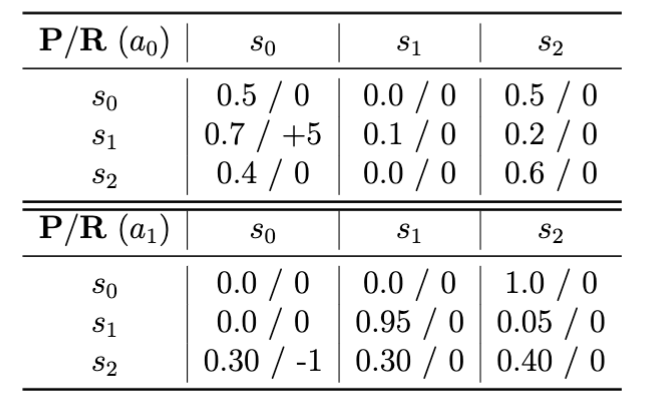

### the transition and reward functions

In [9]:
P0 = np.array([
    [0.5, 0, 0.5],
    [0.7, 0.1, 0.2],
    [0.4, 0, 0.6]])

R0 = np.array([
    [0, 0, 0],
    [5, 0, 0],
    [0, 0, 0]])

P1 = np.array([
    [0, 0, 1],
    [0, 0.95, 0.05],
    [0.3, 0.3, 0.4]])

R1 = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [-1, 0, 0]])

### 1. Value iteration

In [10]:
# initialize the state value function
Q = np.zeros((3,1))
gamma = 0.9

for i in range(10):
    Q0 = (R0 * P0).sum(1).reshape(-1,1) + \
            gamma * (P0 @ Q.reshape(-1, 1))

    Q1 = (R1 * P1).sum(1).reshape(-1,1) + \
            gamma * (P1 @ Q.reshape(-1, 1))

    Q = np.maximum(Q0, Q1)
    Q -= np.mean(Q)
    print (f"--- iter {i} ---")
    print (f"choice: {((Q0 < Q1).flatten())}")
    print (f"Q: {Q.flatten()}")
    print ()

--- iter 0 ---
choice: [False False False]
Q: [-1.16666667  2.33333333 -1.16666667]

--- iter 1 ---
choice: [False False  True]
Q: [-1.48666667  2.32833333 -0.84166667]

--- iter 2 ---
choice: [ True False  True]
Q: [-1.25356667  2.12538333 -0.87181667]

--- iter 3 ---
choice: [ True False  True]
Q: [-1.31180567  2.21743983 -0.90563417]

--- iter 4 ---
choice: [ True False  True]
Q: [-1.3195841   2.20560452 -0.88602042]

--- iter 5 ---
choice: [ True False  True]
Q: [-1.30759256  2.19750857 -0.88991602]

--- iter 6 ---
choice: [ True False  True]
Q: [-1.31185465  2.20287734 -0.89102268]

--- iter 7 ---
choice: [ True False  True]
Q: [-1.31168508  2.20164178 -0.8899567 ]

--- iter 8 ---
choice: [ True False  True]
Q: [-1.31113997  2.20141502 -0.89027504]

--- iter 9 ---
choice: [ True False  True]
Q: [-1.31140999  2.2016972  -0.89028721]



### 2. Policy iteration

In [11]:
# initialize the policy (all choose a0)
Pi = np.array([0, 0, 0])
# initialize state value function randomly
Q = np.random.random((3,1))
gamma = 0.9
    
for i in range(5):
    print (f"--- iter {i} ---")
    
    Q0 = (R0 * P0).sum(1).reshape(-1,1) + \
            gamma * (P0 @ Q.reshape(-1, 1))

    Q1 = (R1 * P1).sum(1).reshape(-1,1) + \
            gamma * (P1 @ Q.reshape(-1, 1))

    # policy evaluation
    Q = Q0 * (1 - Pi).reshape(-1, 1) + Q1 * Pi.reshape(-1, 1) 
    Q -= Q.mean()
    print (f"cur state valie: {Q.flatten()}")
    
    
    Q0 = (R0 * P0).sum(1).reshape(-1,1) + \
            gamma * (P0 @ Q.reshape(-1, 1))

    Q1 = (R1 * P1).sum(1).reshape(-1,1) + \
            gamma * (P1 @ Q.reshape(-1, 1))

    # policy improvement
    Pi = (Q0 < Q1).astype("int").flatten()
    print (f"policy: {Pi}")
    print ()

--- iter 0 ---
cur state valie: [-1.18199503  2.37401528 -1.19202025]
policy: [0 0 1]

--- iter 1 ---
cur state valie: [-1.49459093  2.32815681 -0.83356588]
policy: [1 0 1]

--- iter 2 ---
cur state valie: [-1.24776587  2.12034338 -0.87257751]
policy: [1 0 1]

--- iter 3 ---
cur state valie: [-1.31326067  2.21973355 -0.90647288]
policy: [1 0 1]

--- iter 4 ---
cur state valie: [-1.3197751   2.20530717 -0.88553207]
policy: [1 0 1]



### 3. Q-learning

In [12]:
# initialize the Q(s,a) table
Q = np.zeros((10, 2))

alpha = 0.1
gamma = 0.95

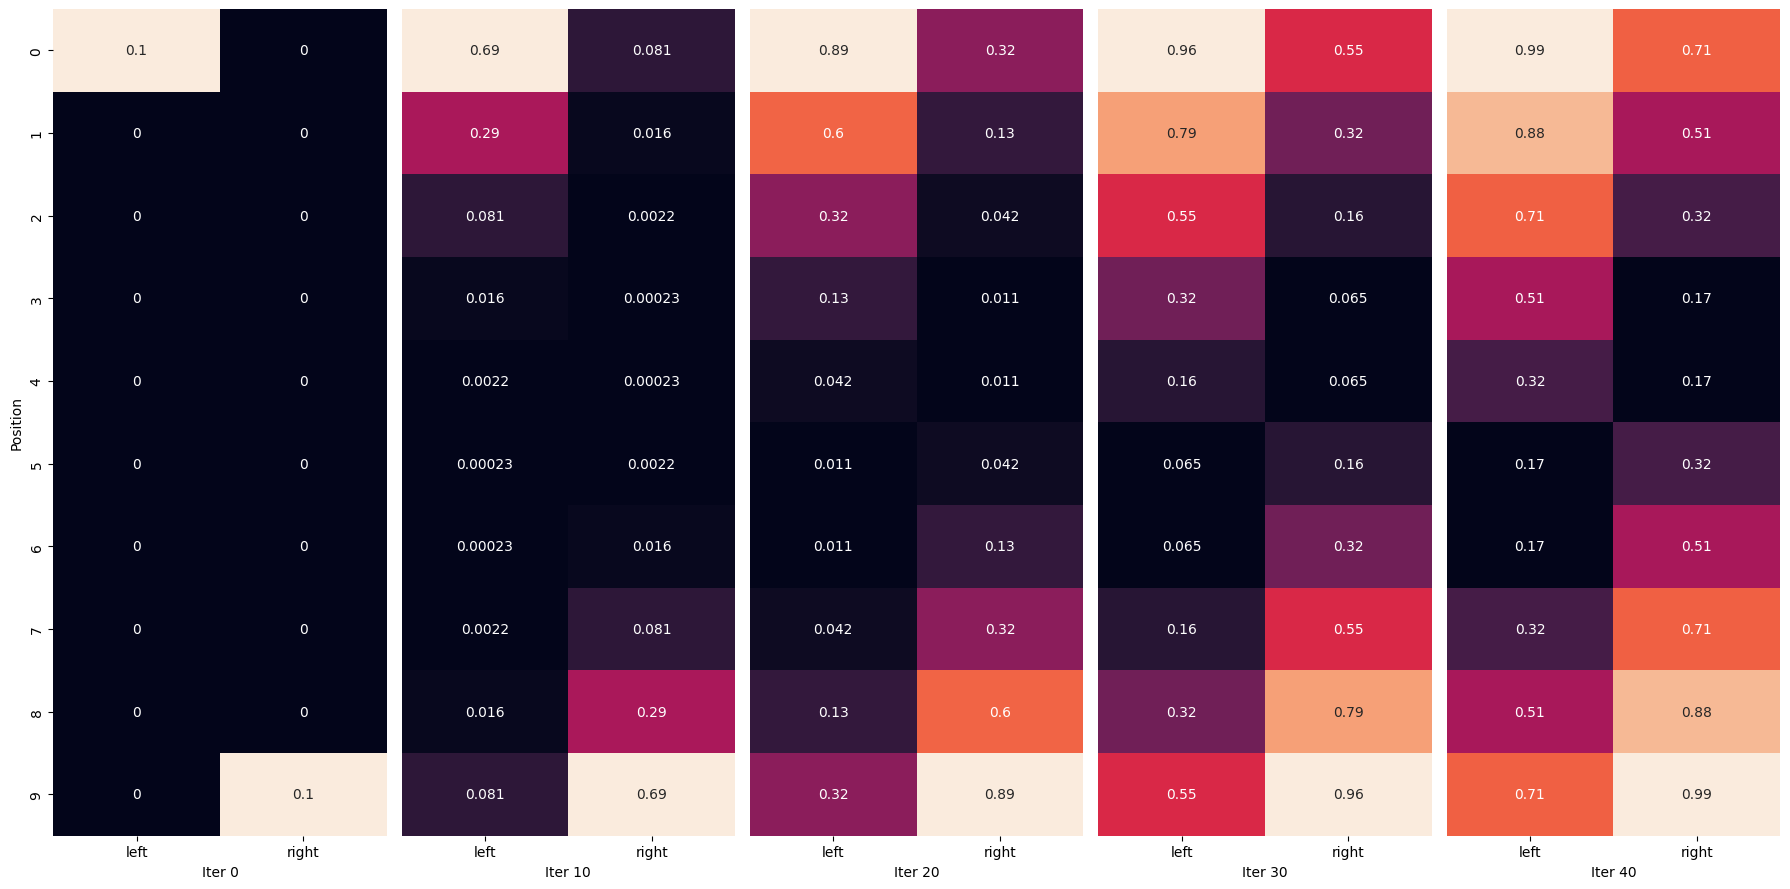

In [13]:
import seaborn as sns

plt.figure(figsize=(18,9))

for i in range(50):
    Q_ = Q.copy()
    for s in range(10):
        for a in range(2):
            if (s == 9) and (a == 1) or (s == 0) and (a == 0):
                Q_[s,a] = Q[s,a] + alpha * (1 - Q[s,a])
            elif (a == 0):
                Q_[s,a] = Q[s,a] + alpha * (0 + gamma * max(Q[s-1,:]) - Q[s,a])
            elif (a == 1):
                Q_[s,a] = Q[s,a] + alpha * (0 + gamma * max(Q[s+1,:]) - Q[s,a])
            else:
                raise NotImplementedError
    Q = Q_
    if i % 10 == 0:
        ax = plt.subplot(1, 5, i // 10 + 1)
        sns.heatmap(Q, annot=True, cbar=False)
        plt.xlabel(f"Iter {i}")
        ax.set_xticks([0.5, 1.5], ["left", "right"])
        
        if i != 0:
            ax.set_yticks([])
        
        if i == 0:
            plt.ylabel(f"Position")

plt.tight_layout()

### 4. Deep Q-Network (DQN)

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

S = np.arange(12) # position 0, 1, ..., 9 + two end state (left wall, and right wall)
A = np.arange(2)  # action 0, 1

class DQN(nn.Module):
    def __init__(self, lenS, lenA):
        super().__init__()
        # initialize the embeddings for state and action
        self.s_embed = nn.Embedding(lenS, 16)
        self.a_embed = nn.Embedding(lenA, 16)
        # build a two-layer neural network
        self.Q = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, s, a):
        # obtain the embedding for state s and action a
        s_emb = self.s_embed(s)
        a_emb = self.a_embed(a)
        
        # concatenate the embeddings and map to the value Q(s,a)
        predicted = self.Q(s_emb + a_emb)
        return predicted

model = DQN(len(S), len(A))

/home/chaoqiy2/miniconda3/envs/moltext/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 4.1 generate training samples $(s_i,a_i,r_i,s_{i+1})$

In [15]:
# the environment feedbacks
def env(s, a):
    if (s == 0) and (a == 0):
        return 1, 10
    elif (s == 9) and (a == 1):
        return 1, 11
    elif (a == 0):
        return 0, s - 1
    elif (a == 1):
        return 0, s + 1
    else:
        raise NotImplementedError
    
# we randomly generate 10000 samples
samples = []
for _ in range(1000):
    s = np.random.choice(S[:10], 1)[0]
    a = np.random.choice(A, 1)[0]
    r, s_ = env(s, a)
    samples.append([s, a, r, s_])

samples = np.array(samples)

# split the S, A, R, S_ to separate variables
train_S = torch.LongTensor(samples[:, 0])
train_A = torch.LongTensor(samples[:, 1])
train_R = torch.FloatTensor(samples[:, 2])
train_S_ = torch.LongTensor(samples[:, 3])

#### 4.2 model training

In [16]:
alpha = 0.1
gamma = 0.95

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

model.train()
for epoch in range(400):
    # predicted Q(s, a)
    pre = model(train_S, train_A)
    
    # target Q(s, a)
    with torch.no_grad():
        max_part = torch.maximum(model(train_S_, torch.zeros_like(train_S_)), \
                                 model(train_S_, torch.ones_like(train_S_)))
        target = pre + alpha * (train_R.unsqueeze(1) + gamma * max_part - pre)

    loss = criterion(pre, target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print (f"--- epoch: {epoch} ---, trainig loss: {loss.item()}")


--- epoch: 0 ---, trainig loss: 0.0008820003713481128
--- epoch: 50 ---, trainig loss: 0.0006625005044043064
--- epoch: 100 ---, trainig loss: 0.0005878139636479318
--- epoch: 150 ---, trainig loss: 0.0005082088173367083
--- epoch: 200 ---, trainig loss: 0.0004394527350086719
--- epoch: 250 ---, trainig loss: 0.0004060779756400734
--- epoch: 300 ---, trainig loss: 0.000383451406378299
--- epoch: 350 ---, trainig loss: 0.000368350010830909


#### 4.3 print out the Q(s,a) function

In [17]:
for i in range(10):
    print (f"(s={i}, a={a}): {model(torch.LongTensor([i]), torch.LongTensor([0])).item()}", end="")
    print (f", (s={i}, a={a}): {model(torch.LongTensor([i]), torch.LongTensor([1])).item()}", end="")
    print ()

(s=0, a=1): 0.987571120262146, (s=0, a=1): 0.9697204232215881
(s=1, a=1): 0.9374898672103882, (s=1, a=1): 0.8202891945838928
(s=2, a=1): 0.8651662468910217, (s=2, a=1): 0.8006110191345215
(s=3, a=1): 0.8190135359764099, (s=3, a=1): 0.7122568488121033
(s=4, a=1): 0.7358948588371277, (s=4, a=1): 0.7466285228729248
(s=5, a=1): 0.7129628658294678, (s=5, a=1): 0.7220211625099182
(s=6, a=1): 0.7443598508834839, (s=6, a=1): 0.7623758912086487
(s=7, a=1): 0.73502516746521, (s=7, a=1): 0.8407372236251831
(s=8, a=1): 0.8021562099456787, (s=8, a=1): 0.9124886989593506
(s=9, a=1): 0.9523698687553406, (s=9, a=1): 0.9807924628257751


### 5. Policy Gradient

#### 5.1 sample trajectory

In [18]:
import numpy as np

# the environment feedbacks
def env(s, a):
    if (s == 0) and (a == 0):
        return 1, 10
    elif (s == 9) and (a == 1):
        return 1, 11
    elif (a == 0):
        return 0, s - 1
    elif (a == 1):
        return 0, s + 1
    else:
        raise NotImplementedError
        
        
# simulate K trajectory based on the current theta
"""
Store trajectories and the total rewards
 - trajs is a list of list structure, the inner list is the (s,a) pair
 - Rs is a list of total rewards
"""
trajs, Rs = [], []
K = 100

for k in range(K):
    # store for one trajectory
    traj, R = [], 0

    # randomly choose a start
    s = np.random.choice(S, 1)[0]

    # keep running the agent based on the policy and stop after len(traj) >= 20
    # the len(traj) condition is useful for code start
    while (s < 10) and (len(traj) <= 10):
        a = 0 if np.random.random() > 0.5 else 1
        # store (s, a) pair
        traj.append([s, a])
        # transit to next state and get reward
        r, s = env(s, a)
        # add step reward to total reward
        R += r

    # stores the k-th trajectory and total reward
    trajs.append(traj)
    Rs.append(R) 

#### 5.2 define the policy gradient model

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

S = np.arange(10) # position 0, 1, ..., 9
        
class PG(nn.Module):
    def __init__(self, lenS):
        super().__init__()
        
        # define the state embedding table
        self.state_emb = nn.Embedding(lenS, 16)
        
        # two-layer neural netowork as the policy
        self.policy = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, s):
        # retrive embeddings from state embedding tables
        s_emb = self.state_emb(s)
        
        # generate the action probability based on s
        out = self.policy(s_emb)
        return out
    
model = PG(len(S))

#### 5.3 model training

In [20]:
# set model optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

for epoch in range(100):
    loss = 0
    for k in range(K):
        # load the k-th trajectory and total reward
        R = Rs[k]
        traj = np.array(trajs[k])
        s = torch.LongTensor([pair[0] for pair in trajs[k]])
        a = torch.LongTensor([pair[1] for pair in trajs[k]])
        prob = model(s).squeeze(1)
        
        probs = torch.log(torch.where(a == 0, prob, 1 - prob)).sum()
        loss += probs * R
    
    loss = - loss / K
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print (f"--- epoch: {epoch} ---, training loss: {loss.item()}")

--- epoch: 0 ---, training loss: 1.2978529930114746
--- epoch: 10 ---, training loss: 1.1420787572860718
--- epoch: 20 ---, training loss: 1.0717012882232666
--- epoch: 30 ---, training loss: 1.038751244544983
--- epoch: 40 ---, training loss: 1.0357904434204102
--- epoch: 50 ---, training loss: 1.0335326194763184
--- epoch: 60 ---, training loss: 1.033341884613037
--- epoch: 70 ---, training loss: 1.032975196838379
--- epoch: 80 ---, training loss: 1.0329389572143555
--- epoch: 90 ---, training loss: 1.0329153537750244


#### 5.4 print the best action

In [21]:
for i in range(10):
    prob = model(torch.LongTensor([i])).item()
    print (f"position: {i}, best action: {0 if prob > 0.5 else 1}")

position: 0, best action: 0
position: 1, best action: 0
position: 2, best action: 0
position: 3, best action: 0
position: 4, best action: 0
position: 5, best action: 1
position: 6, best action: 1
position: 7, best action: 1
position: 8, best action: 1
position: 9, best action: 1


### 6. Actor-Critic

#### 6.1 sample trajectories

In [43]:
import numpy as np

# the environment feedbacks
def env(s, a):
    if (s == 0) and (a == 0):
        return 1, 10
    elif (s == 9) and (a == 1):
        return 1, 11
    elif (a == 0):
        return 0, s - 1
    elif (a == 1):
        return 0, s + 1
    else:
        raise NotImplementedError
        
        
# simulate K trajectory based on the current theta
"""
Store trajectories and the total rewards
 - trajs is a list of list structure, the inner list is the (s,a) pair
 - Rs is a list of total rewards
"""
trajs, Rs = [], []
K = 100

for k in range(K):
    # store for one trajectory
    traj = []

    # randomly choose a start
    s0 = np.random.choice(S[:10], 1)[0]

    # keep running the agent based on the policy and stop after len(traj) >= 20
    # the len(traj) condition is useful for code start
    while (s0 < 10) and (len(traj) <= 10):
        a = 0 if np.random.random() > 0.5 else 1
        # transit to next state and get reward
        r, s = env(s0, a)
        # store (s, a) pair
        traj.append([s0, a, r, s])
        s0 = s

    # stores the k-th trajectory and total reward
    trajs.append(traj)

#### 6.2 define the actor-critic model

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
S = np.arange(12) # position 0, 1, ..., 9
A = np.arange(2) # action 0, 1
        
class AC(nn.Module):
    def __init__(self, lenS, lenA):
        super().__init__()
        
        # define the state and action embedding table
        self.state_emb = nn.Embedding(lenS, 16)
        self.action_emb = nn.Embedding(lenA, 16)
        
        # two-layer neural netowork as the policy
        self.actor = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid(),
        )
        # two-layer neural network as the Q function
        self.critic = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )
        
    # the part for critic
    def evaluate(self, s, a):
        # retrive embeddings from state embedding tables
        s_emb = self.state_emb(s)
        a_emb = self.action_emb(a)
        # evaluate the value of the state 
        value = self.critic(s_emb + a_emb)
        return value
    
    # the part for actor
    def forward(self, s):
        # retrive embeddings from state embedding tables
        s_emb = self.state_emb(s)
        # generate the action probability based on s
        out = self.actor(s_emb)
        return out
    
model = AC(len(S), len(A))

#### 6.3 optimize the critic part first

In [45]:
alpha = 0.1
gamma = 0.95

# set model optimizer
critic_criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

model.train()
for epoch in range(400):
    loss = 0
    for k in range(K):
        train_S = torch.LongTensor([pair[0] for pair in trajs[k]])
        train_A = torch.LongTensor([pair[1] for pair in trajs[k]])
        train_R = torch.FloatTensor([pair[2] for pair in trajs[k]])
        train_S_ = torch.LongTensor([pair[3] for pair in trajs[k]])

        # predicted Q(s, a)
        pre = model.evaluate(train_S, train_A)

        # target Q(s, a)
        with torch.no_grad():
            max_part = torch.maximum(model.evaluate(train_S_, torch.zeros_like(train_S_)), model.evaluate(train_S_, torch.ones_like(train_S_)))
            target = pre + alpha * (train_R.unsqueeze(1) + gamma * max_part - pre)
        loss += critic_criterion(pre, target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print (f"--- epoch: {epoch} ---, trainig loss: {loss.item()}")

--- epoch: 0 ---, trainig loss: 0.30390822887420654
--- epoch: 50 ---, trainig loss: 0.1850624978542328
--- epoch: 100 ---, trainig loss: 0.1417054682970047
--- epoch: 150 ---, trainig loss: 0.06955742090940475
--- epoch: 200 ---, trainig loss: 0.02583647519350052
--- epoch: 250 ---, trainig loss: 0.01223271805793047
--- epoch: 300 ---, trainig loss: 0.007148660719394684
--- epoch: 350 ---, trainig loss: 0.003862549550831318


#### 6.4 then train the actor

In [48]:
for epoch in range(200):
    loss = 0
    
    # this part is similar to policy gradient
    for k in range(K):
        train_S = torch.LongTensor([pair[0] for pair in trajs[k]])
        train_A = torch.LongTensor([pair[1] for pair in trajs[k]])
        train_R = torch.FloatTensor([pair[2] for pair in trajs[k]])
        train_S_ = torch.LongTensor([pair[3] for pair in trajs[k]])
        
        """ we use critic to calculate the new reward """
        with torch.no_grad():
            max_Q_S_ = torch.maximum(
                    model.evaluate(train_S_, torch.zeros_like(train_S_)), \
                    model.evaluate(train_S_, torch.ones_like(train_S_))).squeeze(1)
            max_Q_S = torch.maximum(
                    model.evaluate(train_S, torch.zeros_like(train_S)), \
                    model.evaluate(train_S, torch.ones_like(train_S))).squeeze(1)
        train_R += max_Q_S_ - max_Q_S
        
        prob = model(train_S).squeeze(1)
        probs = torch.log(torch.where(train_A == 0, prob, 1 - prob) + 1e-8)
        loss += (probs * train_R).sum()
    
    loss = - loss / K
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print (f"--- epoch: {epoch} ---, trainig loss: {loss.item()}")

--- epoch: 0 ---, trainig loss: -0.3009670078754425
--- epoch: 10 ---, trainig loss: -0.3757290244102478
--- epoch: 20 ---, trainig loss: -0.4588943421840668
--- epoch: 30 ---, trainig loss: -0.550444483757019
--- epoch: 40 ---, trainig loss: -0.6513013243675232
--- epoch: 50 ---, trainig loss: -0.7624937295913696
--- epoch: 60 ---, trainig loss: -0.8853132128715515
--- epoch: 70 ---, trainig loss: -1.0213626623153687
--- epoch: 80 ---, trainig loss: -1.172644853591919
--- epoch: 90 ---, trainig loss: -1.3411014080047607


#### 6.5 find the best action at each position

In [49]:
for i in range(10):
    prob = model(torch.LongTensor([i])).item()
    print (f"position: {i}, prob: {prob}, best action: {0 if prob > 0.5 else 1}")

position: 0, prob: 0.9705571532249451, best action: 0
position: 1, prob: 0.9985383749008179, best action: 0
position: 2, prob: 0.9857069849967957, best action: 0
position: 3, prob: 0.7481907606124878, best action: 0
position: 4, prob: 0.8600860834121704, best action: 0
position: 5, prob: 0.13825270533561707, best action: 1
position: 6, prob: 0.23213940858840942, best action: 1
position: 7, prob: 0.19153252243995667, best action: 1
position: 8, prob: 0.15378323197364807, best action: 1
position: 9, prob: 0.33381515741348267, best action: 1
